In [3]:
from tensorflow.keras.applications import ResNet50,imagenet_utils
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import cv2

In [4]:
def selective_search(image,method='fast'):
  ss=cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(image)
  if method=='fast':
    ss.switchToSelectiveSearchFast()
  else:
    ss.switchToSelectiveSearchQuality()

  rects=ss.process()
  return rects

In [8]:
print("[INFO] loading ResNet...")
model = ResNet50(weights="imagenet")


[INFO] loading ResNet...
102967424/102967424 [==============================] - 6s 0us/step


In [39]:
path='/content/download (1).jpg'

# load the input image from disk and grab its dimensions
image = cv2.imread(path)
(H, W) = image.shape[:2]
method='fast'
conf=0.5

In [40]:

print('Performing Selective Search method')
rects=selective_search(image,method=method)
proposals=[]
boxes=[]


Performing Selective Search method


In [41]:
for(x,y,w,h) in rects:
  if float(w)/W <0.15 or float(h)/H<0.15:
    continue
  roi=image[y:y+h,x:x+w]
  roi=cv2.cvtColor(roi,cv2.COLOR_BGR2RGB)
  roi=cv2.resize(roi,(224,224))
  roi=img_to_array(roi)
  roi=preprocess_input(roi)
  proposals.append(roi)
  boxes.append((x,y,w,h))

In [42]:
proposals=np.array(proposals)
print(f'Proposals shape:{proposals.shape}')
print('Classifying proposals')
preds=model.predict(proposals)
preds=imagenet_utils.decode_predictions(preds,top=1)
labels={}


Proposals shape:(218, 224, 224, 3)
Classifying proposals
7/7 [==============================] - 2s 378ms/step


In [43]:
for (i,p) in enumerate(preds):
  (imagenetID,label,probs)=p[0]
  if label!='beagle':
    continue
  if(probs>=conf):
    (x,y,w,h)=boxes[i]
    box=(x,y,x+w,y+h)
    L=labels.get(label,[])
    L.append((box,probs))
    labels[label]=L


Showing result for beagle


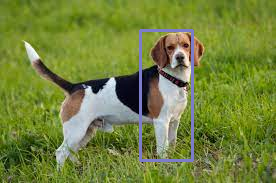

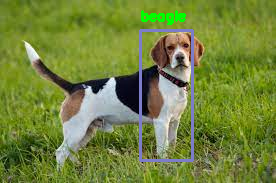

In [44]:
from google.colab.patches import cv2_imshow
for label in labels.keys():
  print(f'Showing result for {label}')
  clone=image.copy()
  for(box,probs) in labels[label]:
    startX,startY,endX,endY=box
    cv2.rectangle(clone,(startX,startY),(endX,endY),(200,125,125),2)
  cv2_imshow(clone)
  clone=image.copy()
  boxes=np.array([p[0] for p in labels[label]])
  proba=np.array([p[1] for p in labels[label]])
  boxes=non_max_suppression(boxes,proba)
  for (startX,startY,endX,endY) in boxes:
    cv2.rectangle(clone,(startX,startY),(endX,endY),(200,125,125),2)
    y=startY-10 if startY-10>10 else startY+10
    cv2.putText(clone,label,(startX,y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
  cv2_imshow(clone)
  cv2.waitKey(0)
